In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [2]:
!pip install adversarial-robustness-toolbox

from art.attacks.inference import model_inversion 
from art.estimators.classification import KerasClassifier

In [3]:
from art.attacks.inference import model_inversion 
from art.estimators.classification import KerasClassifier

In [4]:
def load_mnist():
  """Loads MNIST-Dataset and preprocesses to combine training and test data."""
  
  # load the existing MNIST digit dataset that comes in form of traing + test data and labels
  train, test = tf.keras.datasets.mnist.load_data()
  train_data, train_labels = train
  test_data, test_labels = test

  # scale the images from color values 0-255 to numbers from 0-1 to help the training process
  train_data = np.array(train_data, dtype=np.float32) / 255
  test_data = np.array(test_data, dtype=np.float32) / 255

  # convolutional layers expect images to have 3 dimensions (width, height, depth)
  # in color images the depth is 3 for the RGB channels
  # MNIST is grayscale and hence originally does not need a third dimension
  # so we need to artificially add it
  train_data = train_data.reshape(train_data.shape[0], 28, 28, 1)
  test_data = test_data.reshape(test_data.shape[0], 28, 28, 1)
  return train_data, train_labels, test_data, test_labels
 

In [5]:
def make_model():
  # Define a Keras model
  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)),
      tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
      tf.keras.layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')
  ])
  return model

In [6]:
train_data, train_labels, test_data, test_labels = load_mnist()

In [7]:
# make the neural network model with the function specified above. then look at it
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               204928    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

In [8]:
# specify hyperparameters
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# convert keras model to ART model
classifier = KerasClassifier(model=model, clip_values=(0, 1), use_logits=False)

In [9]:
# train the model
history = classifier.fit(train_data, train_labels,
           batch_size=264, nb_epochs=10)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 13s 216us/sample - loss: 0.5456 - accuracy: 0.8350
Epoch 2/10
60000/60000 [==============================] - 5s 87us/sample - loss: 0.1258 - accuracy: 0.9618
Epoch 3/10
60000/60000 [==============================] - 5s 91us/sample - loss: 0.0910 - accuracy: 0.9722s - loss: 0.092
Epoch 4/10
60000/60000 [==============================] - 6s 92us/sample - loss: 0.0716 - accuracy: 0.9783
Epoch 5/10
60000/60000 [==============================] - 6s 92us/sample - loss: 0.0616 - accuracy: 0.9816
Epoch 6/10
60000/60000 [==============================] - 6s 92us/sample - loss: 0.0532 - accuracy: 0.9840
Epoch 7/10
60000/60000 [==============================] - 6s 94us/sample - loss: 0.0468 - accuracy: 0.9862
Epoch 8/10
60000/60000 [==============================] - 6s 93us/sample - loss: 0.0412 - accuracy: 0.9876
Epoch 9/10
60000/60000 [==============================] - 6s 96us/sample - loss: 0.0380 - accuracy: 0.98

In [11]:
# create an array of the classes to be attacked
y_all = np.arange(10)
y_all

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [11]:
# create the attack object
my_attack = model_inversion.MIFace(classifier)

# average scale color initialization
x_init_average = np.zeros((10, 28, 28, 1)) + np.mean(test_data, axis=0)
inferred_images = my_attack.infer(x_init_average,y=y_all)

Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\Tanvir\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [12]:
inferred_images.shape

(10, 28, 28, 1)

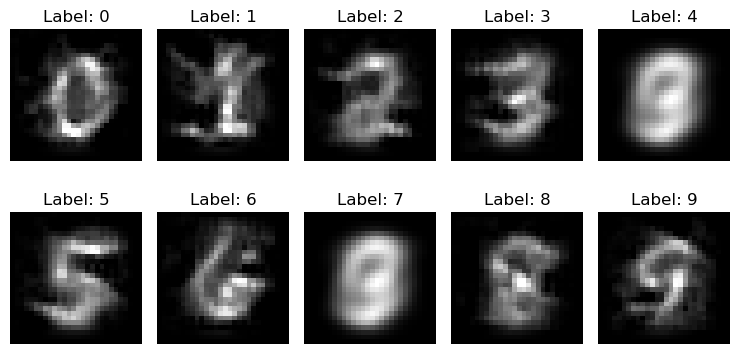

In [14]:
# plot the inverted class representations
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(10):
    ax = axes[i//num_col, i%num_col]
    ax.set_axis_off()
    ax.imshow(inferred_images[i,:,:,:].reshape(28,28), cmap='gray')
    ax.set_title('Label: {}'.format(y_all[i]))

plt.tight_layout()
plt.show()

In [11]:
# create the attack object
my_attack = model_inversion.MIFace(classifier)

# We will experiment with a number of different initializations:

# gray scale color initialization
x_init_grey = np.zeros((10, 28, 28, 1)) + 0.5
inferred_images = my_attack.infer(x_init_grey,y=y_all)

Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\Tanvir\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


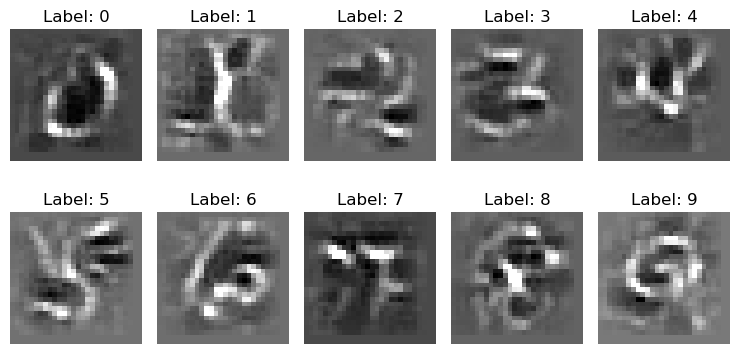

In [12]:
# plot the inverted class representations
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(10):
    ax = axes[i//num_col, i%num_col]
    ax.set_axis_off()
    ax.imshow(inferred_images[i,:,:,:].reshape(28,28), cmap='gray')
    ax.set_title('Label: {}'.format(y_all[i]))

plt.tight_layout()
plt.show()

In [9]:
# train the model with 10 epochs
history = classifier.fit(train_data, train_labels,
           batch_size=264, nb_epochs=5)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 8s 126us/sample - loss: 0.5718 - accuracy: 0.8270
Epoch 2/5
60000/60000 [==============================] - 5s 86us/sample - loss: 0.1295 - accuracy: 0.9607
Epoch 3/5
60000/60000 [==============================] - 5s 91us/sample - loss: 0.0904 - accuracy: 0.9720
Epoch 4/5
60000/60000 [==============================] - 5s 91us/sample - loss: 0.0697 - accuracy: 0.9785
Epoch 5/5
60000/60000 [==============================] - 5s 92us/sample - loss: 0.0594 - accuracy: 0.9819


In [11]:
# create the attack object
my_attack = model_inversion.MIFace(classifier)

# average scale color initialization
x_init_average = np.zeros((10, 28, 28, 1)) + np.mean(test_data, axis=0)
inferred_images = my_attack.infer(x_init_average,y=y_all)

Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\Tanvir\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


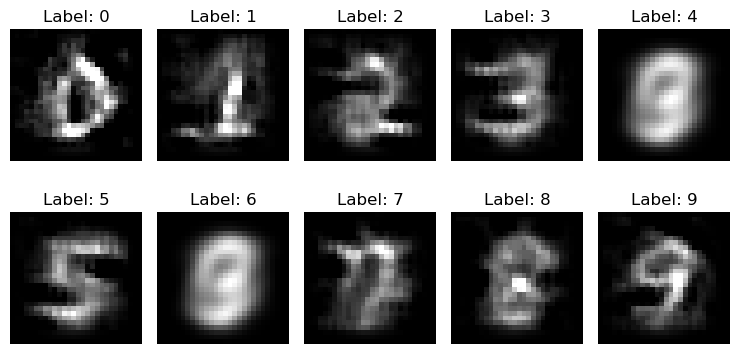

In [12]:
# plot the inverted class representations
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(10):
    ax = axes[i//num_col, i%num_col]
    ax.set_axis_off()
    ax.imshow(inferred_images[i,:,:,:].reshape(28,28), cmap='gray')
    ax.set_title('Label: {}'.format(y_all[i]))

plt.tight_layout()
plt.show()

In [12]:
# create the attack object
my_attack = model_inversion.MIFace(classifier)

# gray scale color initialization
x_init_grey = np.zeros((10, 28, 28, 1)) + 0.5
inferred_images = my_attack.infer(x_init_grey,y=y_all)

Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\Tanvir\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


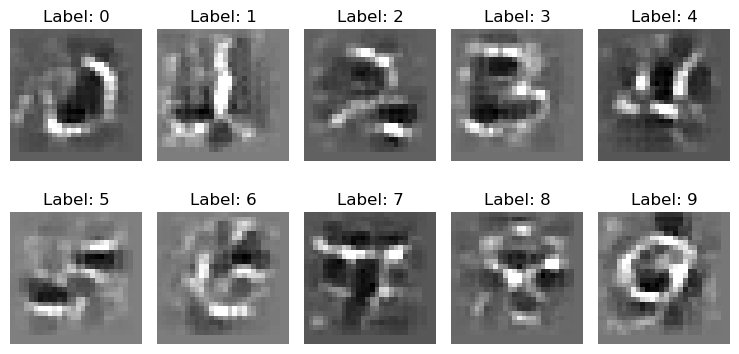

In [13]:
# plot the inverted class representations
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(10):
    ax = axes[i//num_col, i%num_col]
    ax.set_axis_off()
    ax.imshow(inferred_images[i,:,:,:].reshape(28,28), cmap='gray')
    ax.set_title('Label: {}'.format(y_all[i]))

plt.tight_layout()
plt.show()